In [1]:
#Dissipative preparation of tripartite singlet state in coupled arrays of cavities via quantum feedback control
#https://arxiv.org/pdf/1607.05413
#https://arxiv.org/pdf/1607.05413
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

模拟完成。


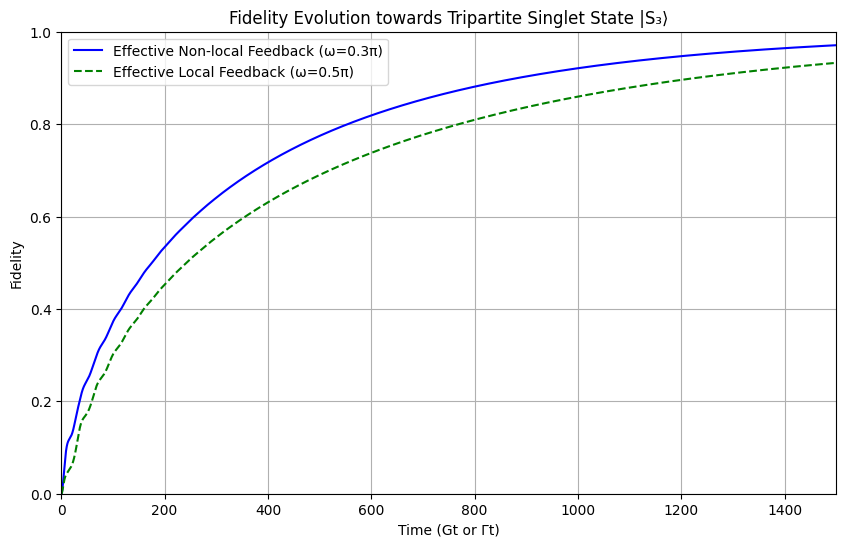

In [4]:

Gamma = 1.0
Omega = 0.1
t_max = 1500
tlist = np.linspace(0, t_max, 60000)
s0 = qt.basis(3, 0) 
s1 = qt.basis(3, 1) 
s2 = qt.basis(3, 2) 
id_q = qt.qeye(3)
P10 = s1 * s0.dag() 
P01 = s0 * s1.dag()  
P12 = s1 * s2.dag()  
P21 = s2 * s1.dag()  

def op_on_atom(op, i):
    """
    辅助函数：将一个单原子算符 op 作用于第 i 个原子上 (i=0, 1, 2)
    """
    ops = [id_q, id_q, id_q]
    ops[i] = op
    return qt.tensor(ops)

J1 = op_on_atom(P10, 0) + op_on_atom(P10, 1) + op_on_atom(P10, 2)
J2 = op_on_atom(P12, 0) + op_on_atom(P12, 1) + op_on_atom(P12, 2)
# |S₃⟩ = (|012⟩ - |102⟩ - |210⟩ + |120⟩ + |201⟩ - |021⟩)/√6
s3_unnormalized = (qt.tensor(s0, s1, s2) - qt.tensor(s1, s0, s2) - qt.tensor(s2, s1, s0) +
                   qt.tensor(s1, s2, s0) + qt.tensor(s2, s0, s1) - qt.tensor(s0, s2, s1))
S3 = s3_unnormalized.unit() # 归一化
psi0 = qt.tensor(s1, s1, s1)
rho0 = psi0 * psi0.dag()

#simulation
#  Lρ 'H function 14
H = Omega * (J1.dag() + J1) + Omega * (J2.dag() + J2)
#collapse 
w_nl = 0.3 * np.pi  

#  def the untarty U = exp[-iω(|1⟩⟨0|+|0⟩⟨1|)_1 - 2iω(|1⟩⟨0|+|0⟩⟨1|)_2]
U_fb = -1j * w_nl * (op_on_atom(P01 + P10, 0) + 2 * op_on_atom(P01 + P10, 1))
U_fb_nl = U_fb.expm()
c_op_nl = np.sqrt(Gamma) * U_fb_nl * J1
c_ops_nl = [c_op_nl]
# Eq. (16)
w_loc = 0.5 * np.pi # 局域反馈频率，来自图5的说明
#famadule 16
U_fb_0 = -1j * w_loc * op_on_atom(P01 + P10, 0)
U_fb_1 = -1j * w_loc * op_on_atom(P01 + P10, 1)
U_fb_2 = -1j * w_loc * op_on_atom(P01 + P10, 2)

U_fb_loc_0 = U_fb_0.expm()
U_fb_loc_1 = U_fb_1.expm()
U_fb_loc_2 = U_fb_2.expm()
c_op_loc_0 = np.sqrt(Gamma / 3.0) * U_fb_loc_0 * J1
c_op_loc_1 = np.sqrt(Gamma / 3.0) * U_fb_loc_1 * J1
c_op_loc_2 = np.sqrt(Gamma / 3.0) * U_fb_loc_2 * J1
c_ops_loc = [c_op_loc_0, c_op_loc_1, c_op_loc_2]



result_nl = qt.mesolve(H, rho0, tlist, c_ops_nl, e_ops=[])
result_loc = qt.mesolve(H, rho0, tlist, c_ops_loc, e_ops=[])


def calculate_fidelity(states, target_psi):
    """计算保真度 F = sqrt(<psi|rho|psi>) """
    overlaps = qt.expect(target_psi * target_psi.dag(), states)
    return np.sqrt(np.real(overlaps)) 
fidelities_nl = calculate_fidelity(result_nl.states, S3)
fidelities_loc = calculate_fidelity(result_loc.states, S3)

plt.figure(figsize=(10, 6))
plt.plot(tlist, fidelities_nl, label='Effective Non-local Feedback (ω=0.3π)', color='blue', linestyle='-')
plt.plot(tlist, fidelities_loc, label='Effective Local Feedback (ω=0.5π)', color='green', linestyle='--')

plt.title('Fidelity Evolution towards Tripartite Singlet State |S₃⟩')
plt.xlabel('Time (Gt or Γt)')
plt.ylabel('Fidelity')
plt.grid(True)
plt.legend()
plt.ylim(0, 1.0)
plt.xlim(0, t_max)
plt.show()